In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad", patient_id_col="patient_id")  # read a .h5ad file

2023-04-18 09:13:38,092 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/tutorial/diamandis.h5ad
2023-04-18 09:13:38,117 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040062,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684864e+14,3.112051e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638138,0.763087


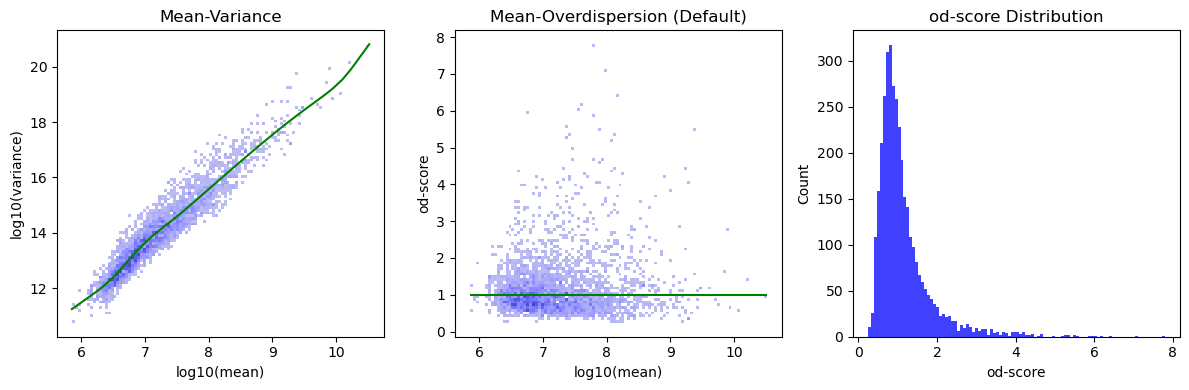

In [8]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-04-18 09:13:44,894 [INFO] 1612 genes selected for factorization


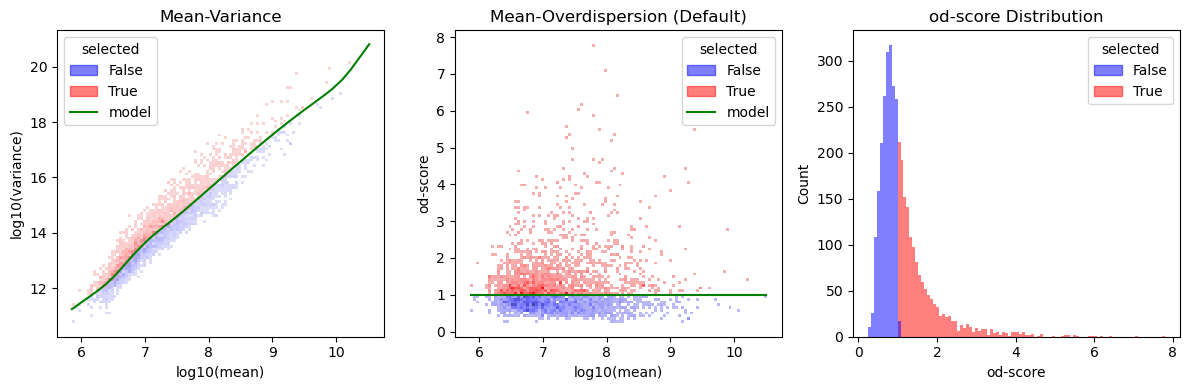

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-04-18 09:13:49,830 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-04-18 09:13:49,831 [INFO] Merging iterations for k=2
2023-04-18 09:13:49,833 [INFO] Combining factorizations for k=2.
2023-04-18 09:13:49,865 [INFO] Merging iterations for k=3
2023-04-18 09:13:49,867 [INFO] Combining factorizations for k=3.
2023-04-18 09:13:49,900 [INFO] Merging iterations for k=4
2023-04-18 09:13:49,902 [INFO] Combining factorizations for k=4.
2023-04-18 09:13:49,938 [INFO] Merging iterations for k=5
2023-04-18 09:13:49,940 [INFO] Combining factorizations for k=5.
2023-04-18 09:13:49,978 [INFO] Merging iterations for k=6
2023-04-18 09:13:49,981 [INFO] Combining factorizations for k=6.
2023-04-18 09:13:50,023 [INFO] Merging iterations for k=7
2023-04-18 09:13:50,025 [INFO] Combining factorizations for k=7.
2023-04-18 09:13:50,069 [INFO] Merging iterations for k=8
2023-04-18 09:13:50,071 [INFO] Combining factorizations for k=8

## Stability-Error Plot

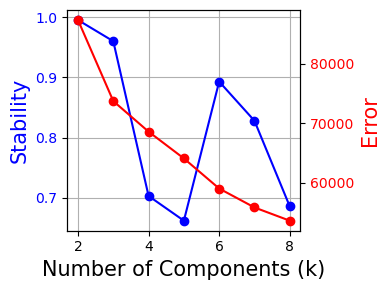

In [12]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [13]:
diamandis.get_usages()

2                       3                          \
                   1           2           1           2           3   
sample_1   286326.16  67990.9200  274935.940  51569.2000   36766.293   
sample_10  275426.22  43044.3240  222565.170  30694.5570   68790.320   
sample_11  304110.84  47006.0860  314174.600  31888.1460   17961.373   
sample_12  325367.20  25237.4360  351379.840   9528.3920    6247.763   
sample_13  322676.66  10176.3200  271438.660   2967.9136   64457.125   
...              ...         ...         ...         ...         ...   
sample_75  381486.70   4416.7056   15505.046   2218.8997  335694.500   
sample_76  340852.60   7805.0854   65813.670   4315.9890  256208.690   
sample_77  376002.90   5463.2410   30144.857   3904.0156  317185.120   
sample_8   296127.22  25810.0600  303741.900  11711.0510   19373.074   
sample_9   353331.70  24032.3710  358827.120  11168.4760   22017.205   

                    4                                                5  ...  \
                    1           2            3           4           1  ...   
sample_1   244722.100  38597.4380   28673.3340  51720.1250   91318.900  ...   
sample_10  192679.800  20042.0430   60531.6370  53280.0270  123248.790  ...   
sample_11  299162.530  28639.1040   12087.9410  11263.7120  275155.400  ...   
sample_12  335572.000   8957.5120    2724.2004   4905.9700   83795.320  ...   
sample_13  257852.390   1461.0488   57299.9140  14496.3750  192216.300  ...   
...               ...         ...          ...         ...         ...  ...   
sample_75   20959.190   1320.8516  328947.0300   2517.2350   18488.305  ...   
sample_76   68242.414   2159.9026  245816.1100  10916.6680   56031.930  ...   
sample_77   38899.520   2463.4587  306211.7000   4177.8403   35572.150  ...   
sample_8   239812.000   1300.9915   10337.2290  97064.3750  111718.150  ...   
sample_9   345203.500  10565.9150   16064.8730   4913.8447  298166.900  ...   

                     7                       8                           \
                     6           7           1            2           3   
sample_1    51272.8050   6048.9660  31352.8200   61042.3550  53229.5600   
sample_10   21232.5100   1304.6276  17129.8050   46831.7270  11852.9470   
sample_11   25753.0370   5799.1720  28165.3180  217392.6100  17296.8440   
sample_12  256992.1200   2811.6330   2339.7440   64130.9600  17713.6910   
sample_13   26570.1290   1803.3949    624.3564  144169.7200  48031.1300   
...                ...         ...         ...          ...         ...   
sample_75    5102.2550   1571.8527   1194.4540   20579.5570  26000.1600   
sample_76    7144.9746    819.1824   1216.1213   38449.7200   5842.8574   
sample_77    6990.9390   1264.6539    324.6717    1730.8613   2061.4380   
sample_8    25963.4730  12325.6150    765.2857   77662.3600  62166.8120   
sample_9    70346.6640   3209.9790   8892.8070  252854.5200  11662.1890   

                                                                             
                     4             5            6             7           8  
sample_1   181515.3400   11077.97900   43860.3750    8409.23200  4646.62200  
sample_10  145352.3100   12730.51900   14460.6530   95816.39000  1904.73170  
sample_11   17409.4300    8314.69100   21241.9800   28172.16600  4583.46140  
sample_12    9489.1240    1328.80330  244805.9000     157.81236  2214.48630  
sample_13   67877.5000   45793.77300   22092.7460    8772.95600  1300.95120  
...                ...           ...          ...           ...         ...  
sample_75    4563.2974  292265.72000    4437.4097    6511.82000  1440.06420  
sample_76   51859.7800  210899.40000    5275.3013   25160.23600   729.07086  
sample_77    2585.7593  206323.03000    1118.0721  135870.27000   893.30790  
sample_8   204572.3600     900.25183   19480.3520     129.02065  8804.22000  
sample_9     8973.7600   17564.20100   64930.4100     788.24680  1968.67090  

[77 rows x 35 columns]

2023-04-18 09:14:07,395 [INFO] Choosing distinct colors for metadata layer patient_id
2023-04-18 09:14:07,567 [INFO] Choosing distinct colors for metadata layer simple_category
2023-04-18 09:14:07,590 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-04-18 09:14:07,612 [INFO] Choosing distinct colors for metadata layer sex
2023-04-18 09:14:07,620 [INFO] Choosing distinct colors for metadata layer location of resection
2023-04-18 09:14:07,726 [INFO] Choosing distinct colors for metadata layer ATRX
2023-04-18 09:14:07,734 [INFO] Choosing distinct colors for metadata layer p53
2023-04-18 09:14:07,746 [INFO] Choosing distinct colors for metadata layer MGMT


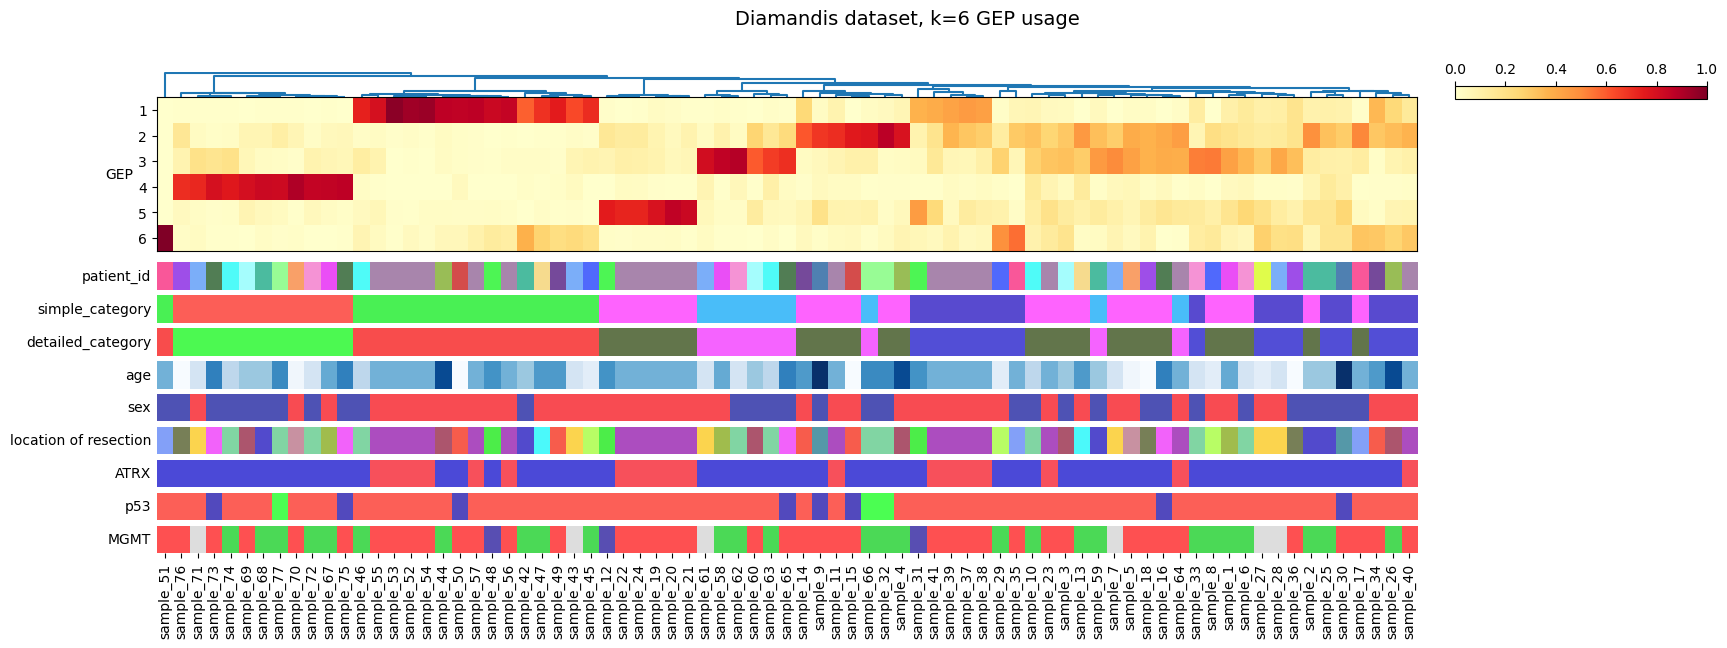

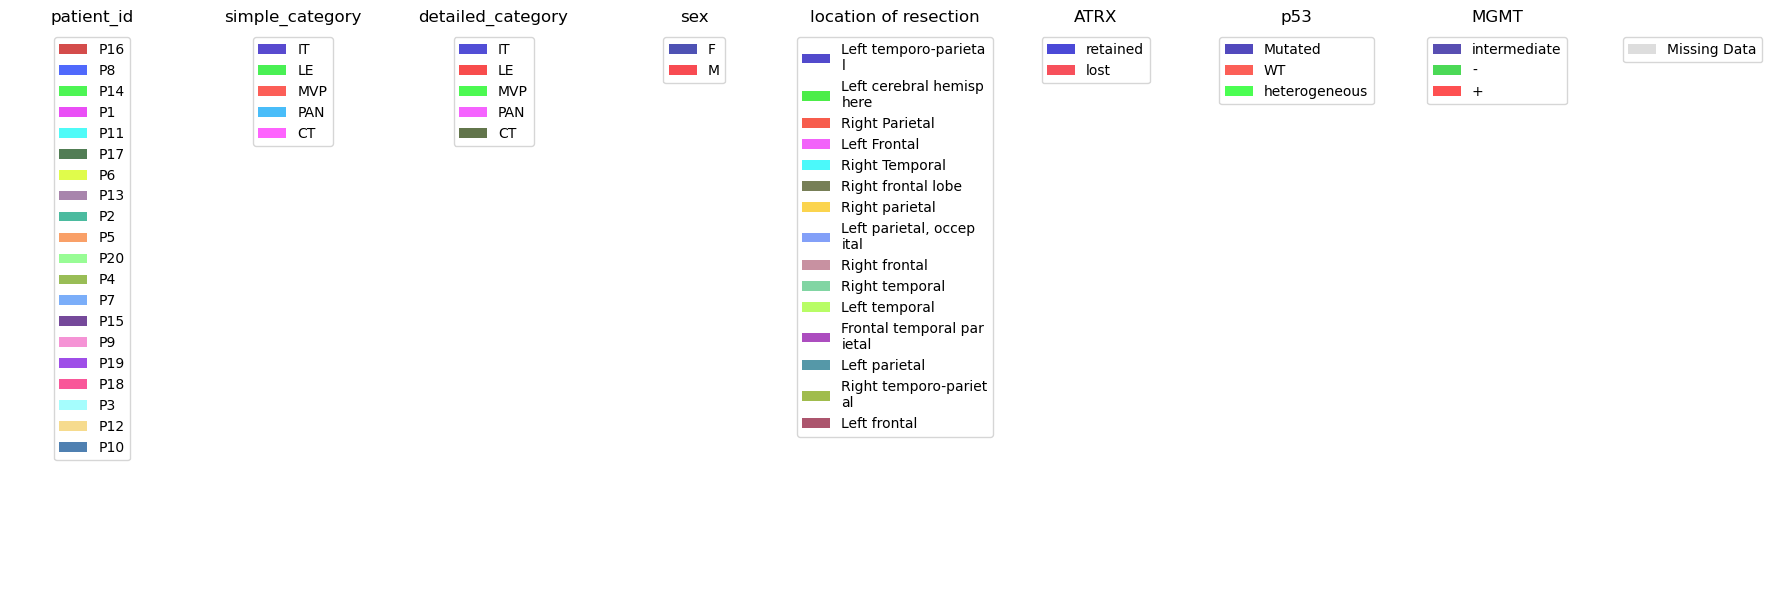

In [14]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [15]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-04-18 09:14:11,911 [INFO] 4554 genes selected for factorization
2023-04-18 09:14:45,311 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-04-18 09:14:45,313 [INFO] Merging iterations for k=2
2023-04-18 09:14:45,317 [INFO] Combining factorizations for k=2.
2023-04-18 09:14:45,419 [INFO] Merging iterations for k=3
2023-04-18 09:14:45,421 [INFO] Combining factorizations for k=3.
2023-04-18 09:14:45,498 [INFO] Merging iterations for k=4
2023-04-18 09:14:45,501 [INFO] Combining factorizations for k=4.
2023-04-18 09:14:45,580 [INFO] Merging iterations for k=5
2023-04-18 09:14:45,584 [INFO] Combining factorizations for k=5.
2023-04-18 09:14:45,672 [INFO] Merging iterations for k=6
2023-04-18 09:14:45,675 [INFO] Combining factorizations for k=6.
2023-04-18 09:14:45,770 [INFO] Merging iterations for k=7
2023-04-18 09:14:45,772 [INFO] Combining factorizations for k=7.
2023-04-18 09:14:45,874 [INFO] Merging iterations fo

## Integrate multiple datasets together

In [16]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-04-18 09:15:11,772 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-04-18 09:15:12,020 [INFO] Choosing distinct dataset colors
2023-04-18 09:15:12,036 [INFO] Choosing distinct colors for metadata layer patient_id
2023-04-18 09:15:17,032 [INFO] Choosing distinct colors for metadata layer simple_category
2023-04-18 09:15:17,046 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-04-18 09:15:17,060 [INFO] Choosing distinct colors for metadata layer multiomic
2023-04-18 09:15:17,077 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-04-18 09:15:17,094 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-04-18 09:15:17,130 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-04-18 09:15:17,186 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-04-18 09:15:17,194 [INFO] Choosing distinct colors for metadata layer immune
2023-04-18 09:15:17,211 [INFO] Choosing di

In [17]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

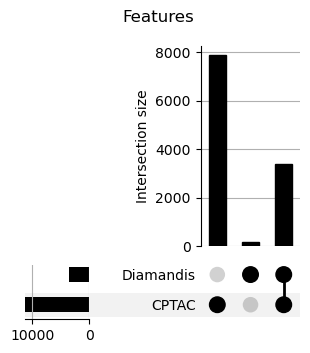

In [18]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

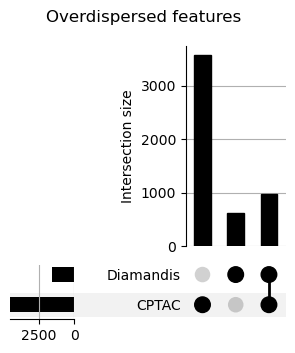

In [19]:
cn.plot_overdispersed_features_upset(integration)

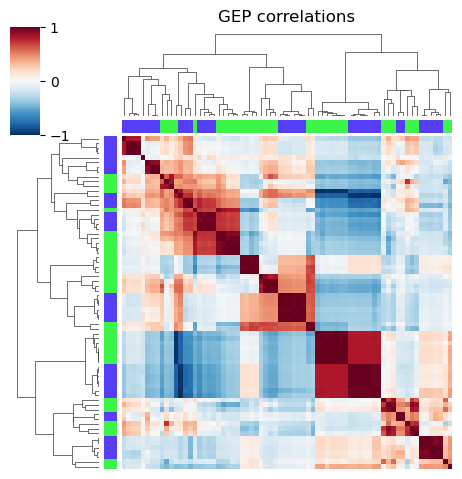

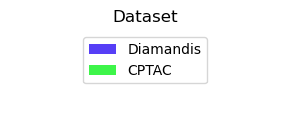

In [20]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [21]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991477    297205.187500       True   
3        True              True         -0.481920    272063.312500       True   
4        True              True         -0.421228    255108.687500       True   
5        True              True         -0.186177    241505.484375       True   
6        True              True         -0.158608    232426.781250       True   
7        True              True         -0.137605    228571.906250       True   
8        True              True         -0.138388    221575.343750       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.993958        True              True         -0.999226     87355.859375   
3  0.805510        True              True         -0.446254     73722.578125   
4  0.732569        True              True         -0.219757     68580.320312   
5  0.666238        True              True         -0.176806     64078.707031   
6  0.621537        True              True         -0.151886     59016.539062   
7  0.482425        True              True         -0.117361     55834.238281   
8  0.478620        True              True         -0.114735     53608.523438   

                        
  selected_k stability  
2       True  0.995667  
3       True  0.960400  
4       True  0.702655  
5       True  0.661496  
6       True  0.893125  
7       True  0.827888  
8       True  0.685332

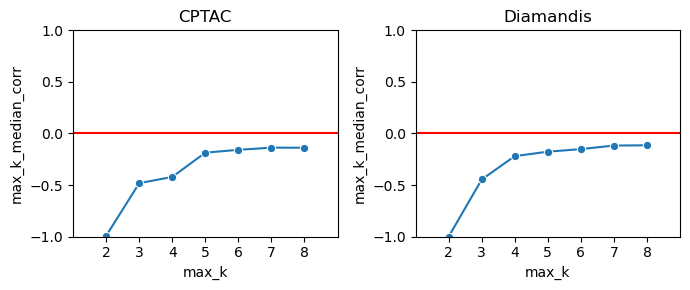

In [22]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

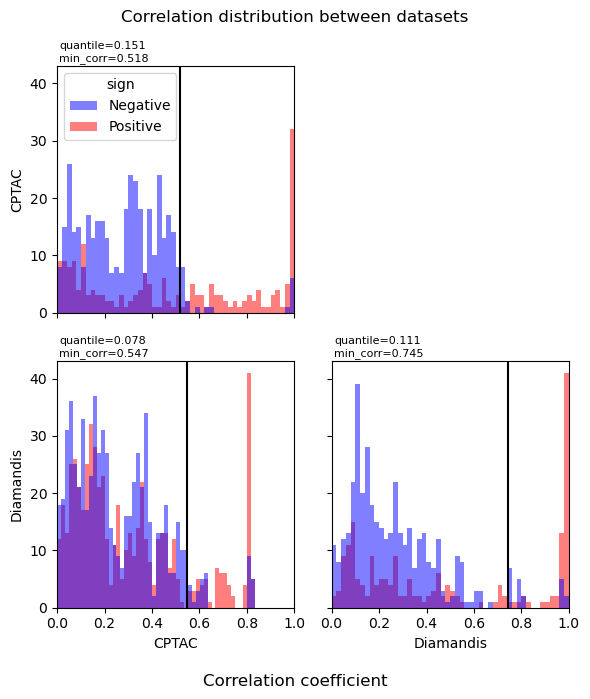

In [23]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [24]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-04-18 09:15:21,071 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-04-18 09:15:21,080 [INFO] Creating community network


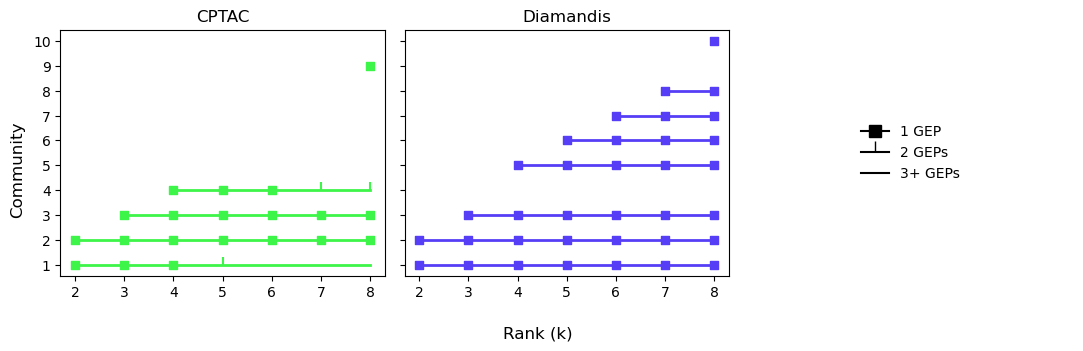

In [25]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

## Prune communities with only 1 node

2023-04-18 14:06:38,907 [INFO] Creating community network


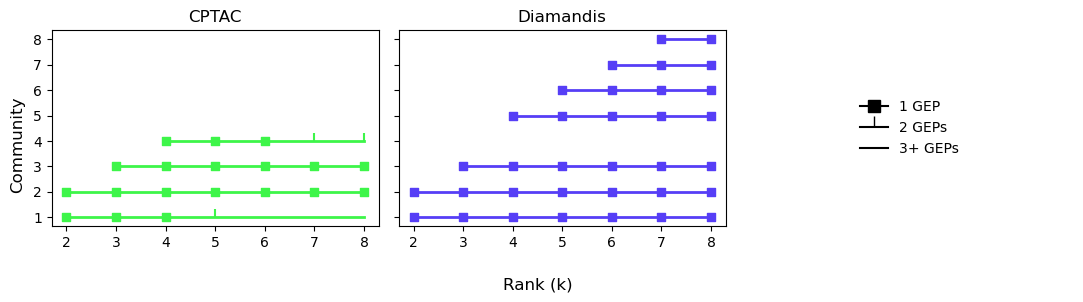

In [43]:
snsmap.prune_communities(min_nodes = 2)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

2023-04-18 14:09:38,146 [INFO] Computing community layout using spring method.


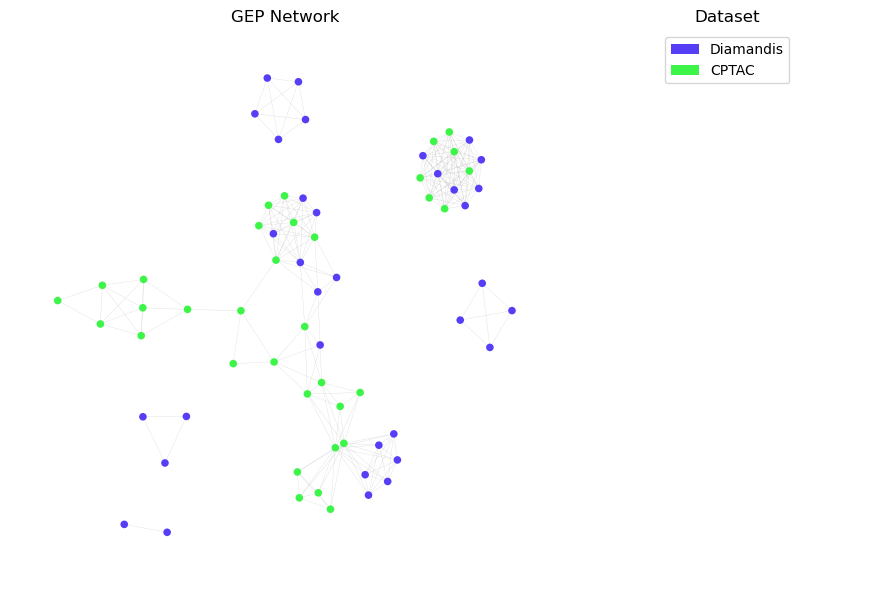

In [51]:
snsmap.compute_layout(algorithm="neato")  # available algorithms: "community_weighted_spring", "spring", "neato"
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

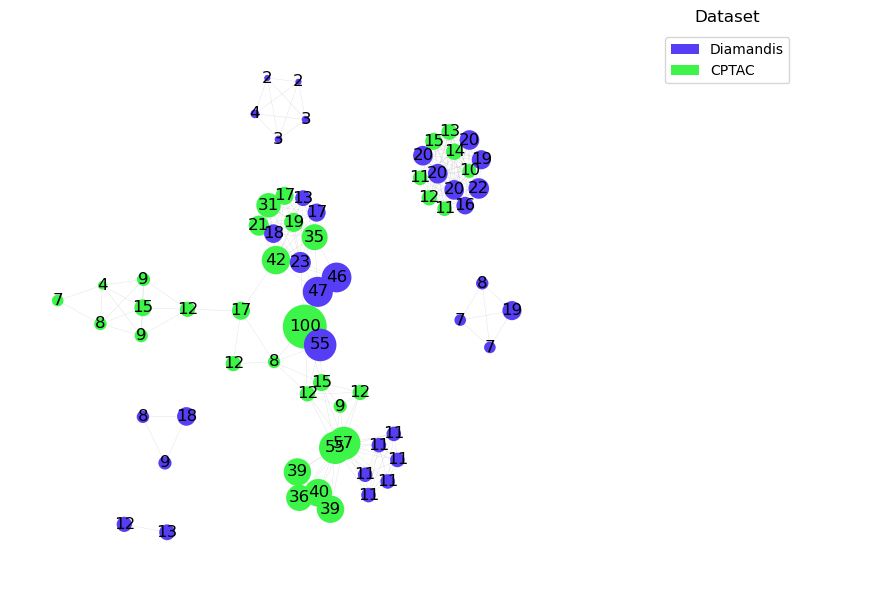

In [52]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

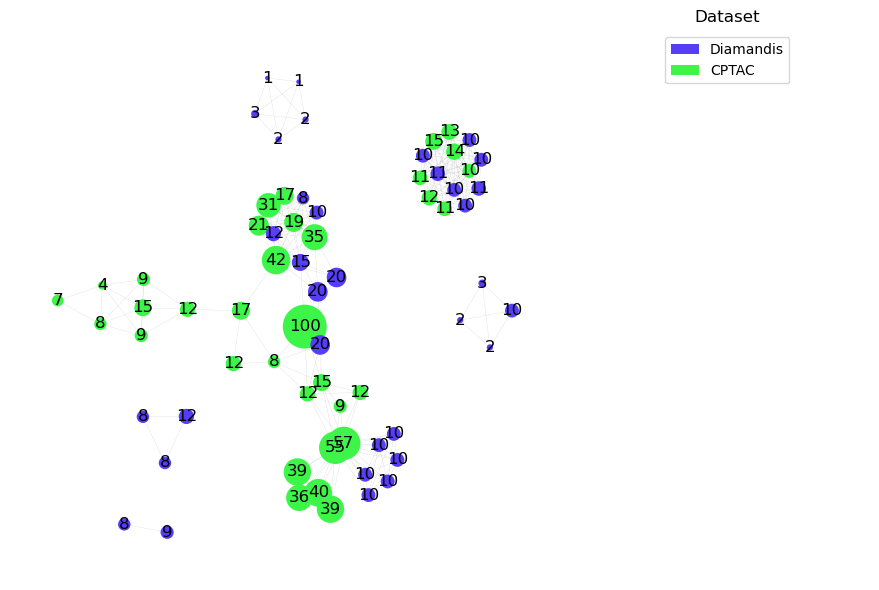

In [46]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

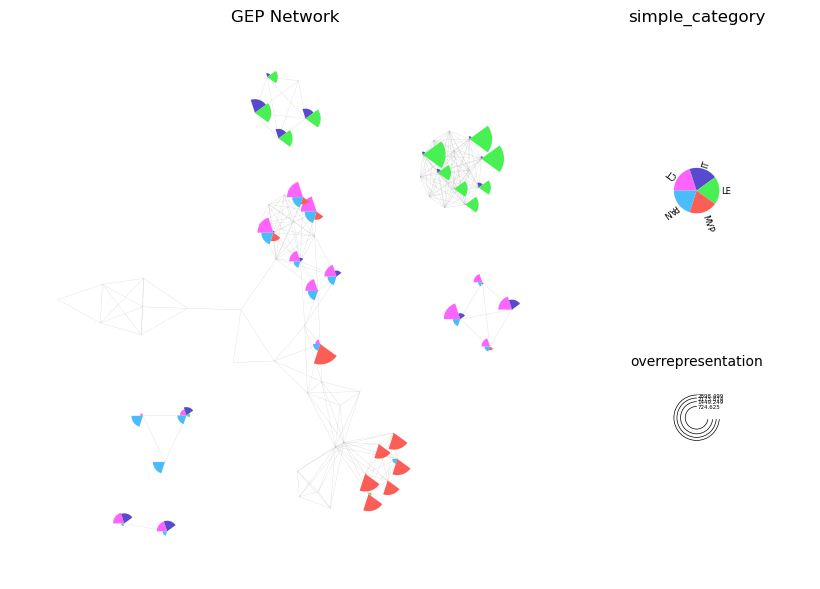

In [47]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

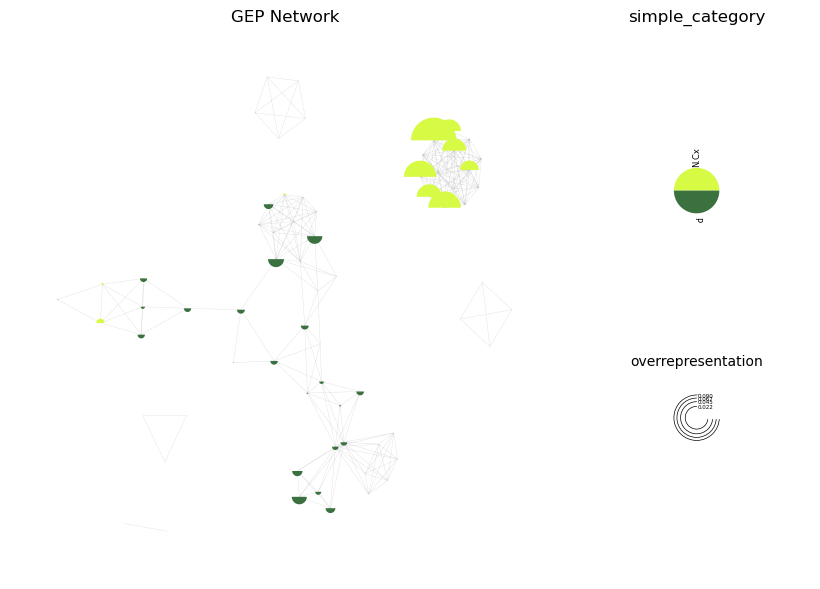

In [48]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-04-18 09:15:23,773 [INFO] Choosing distinct community colors


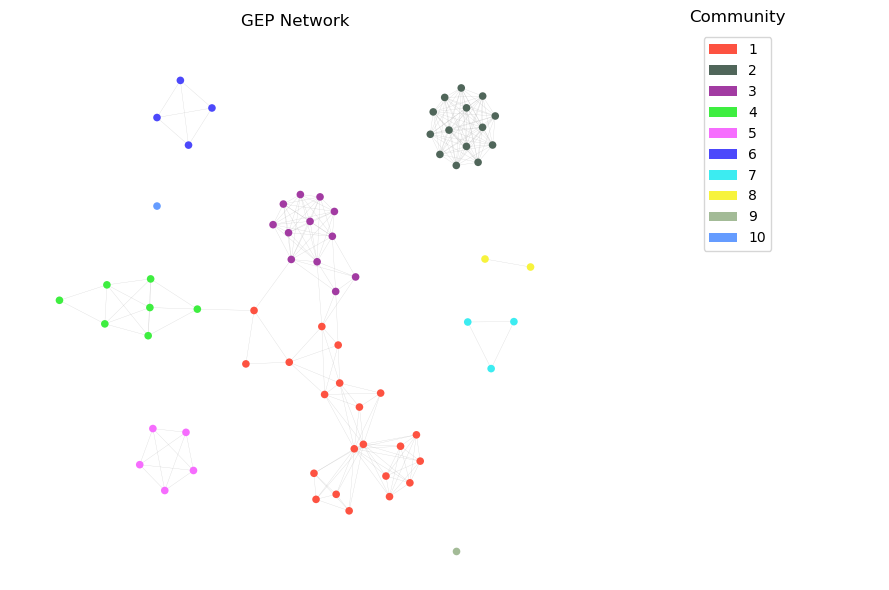

In [31]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

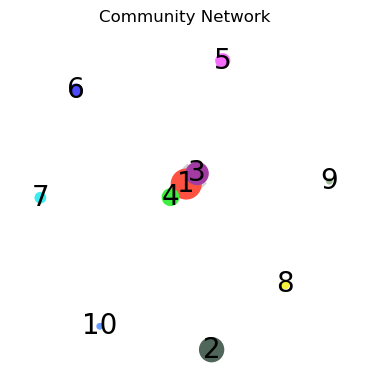

In [32]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

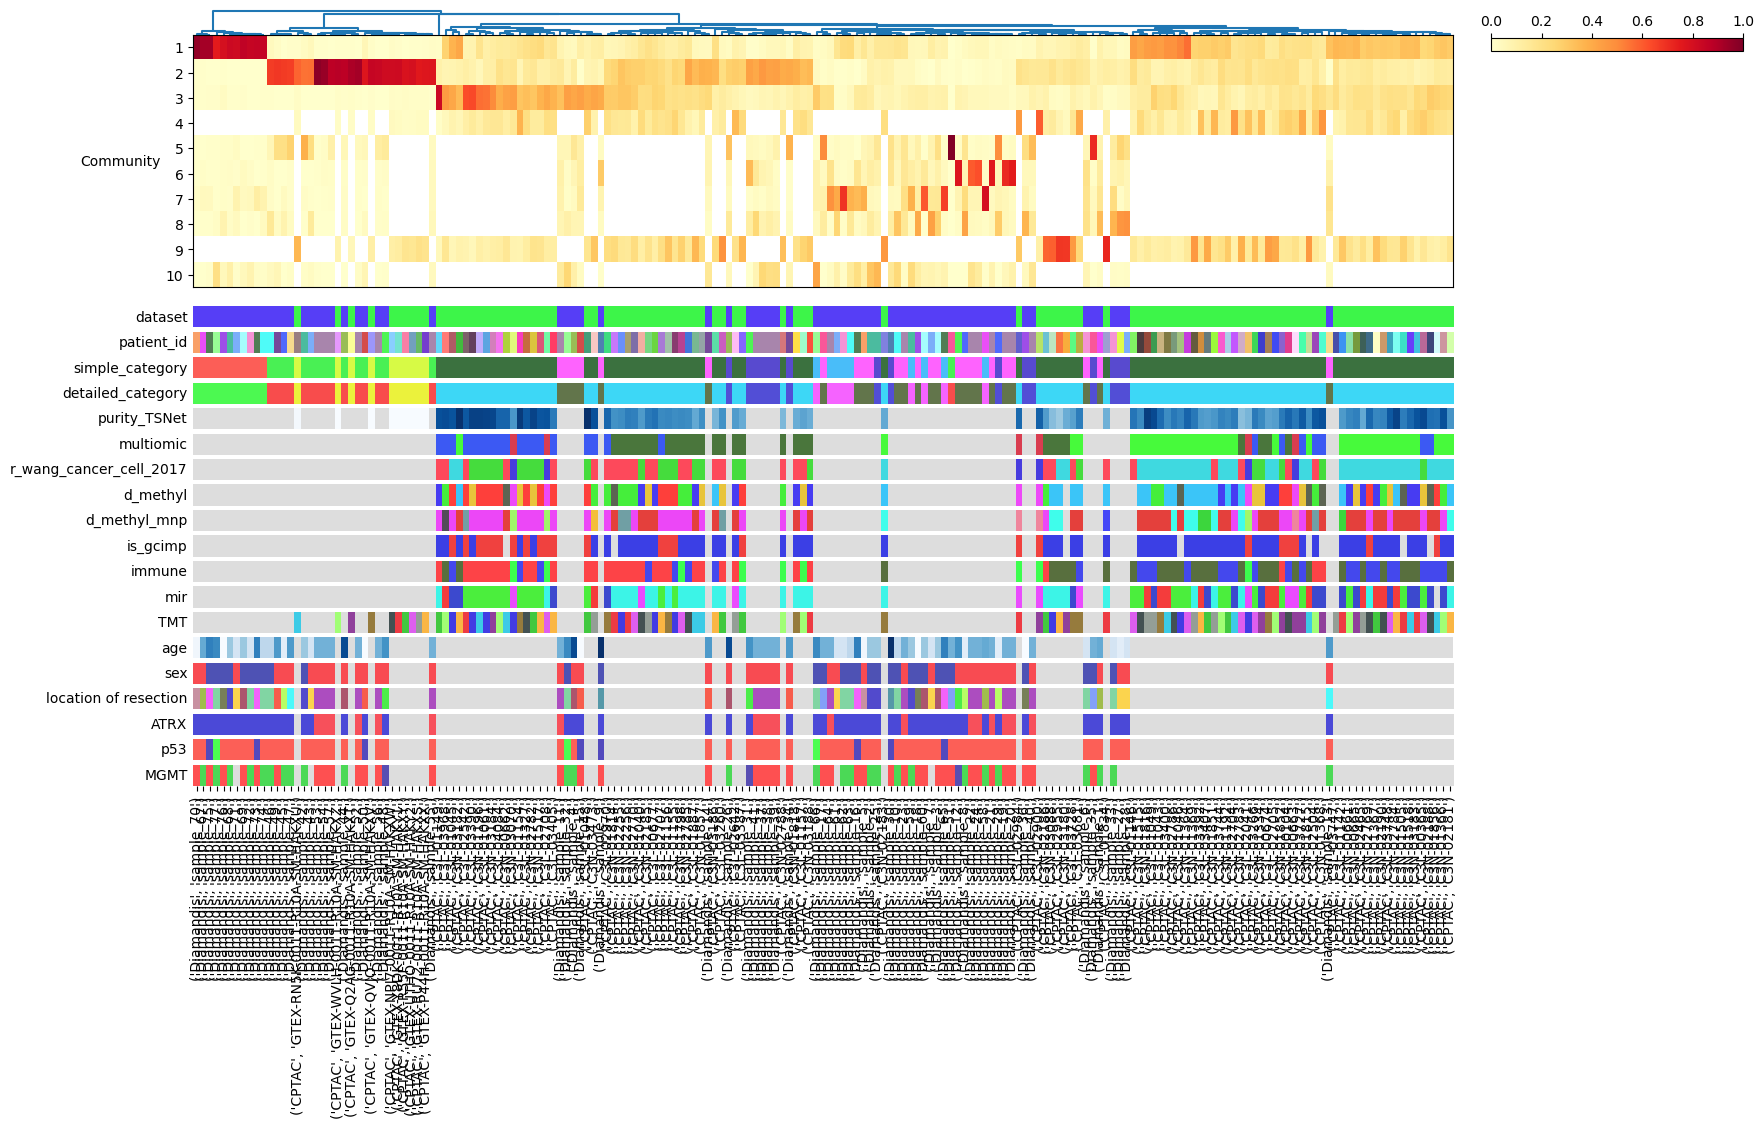

In [33]:
fig = cn.plot_community_usage_heatmap(snsmap, colors, prepend_dataset_colors=True)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

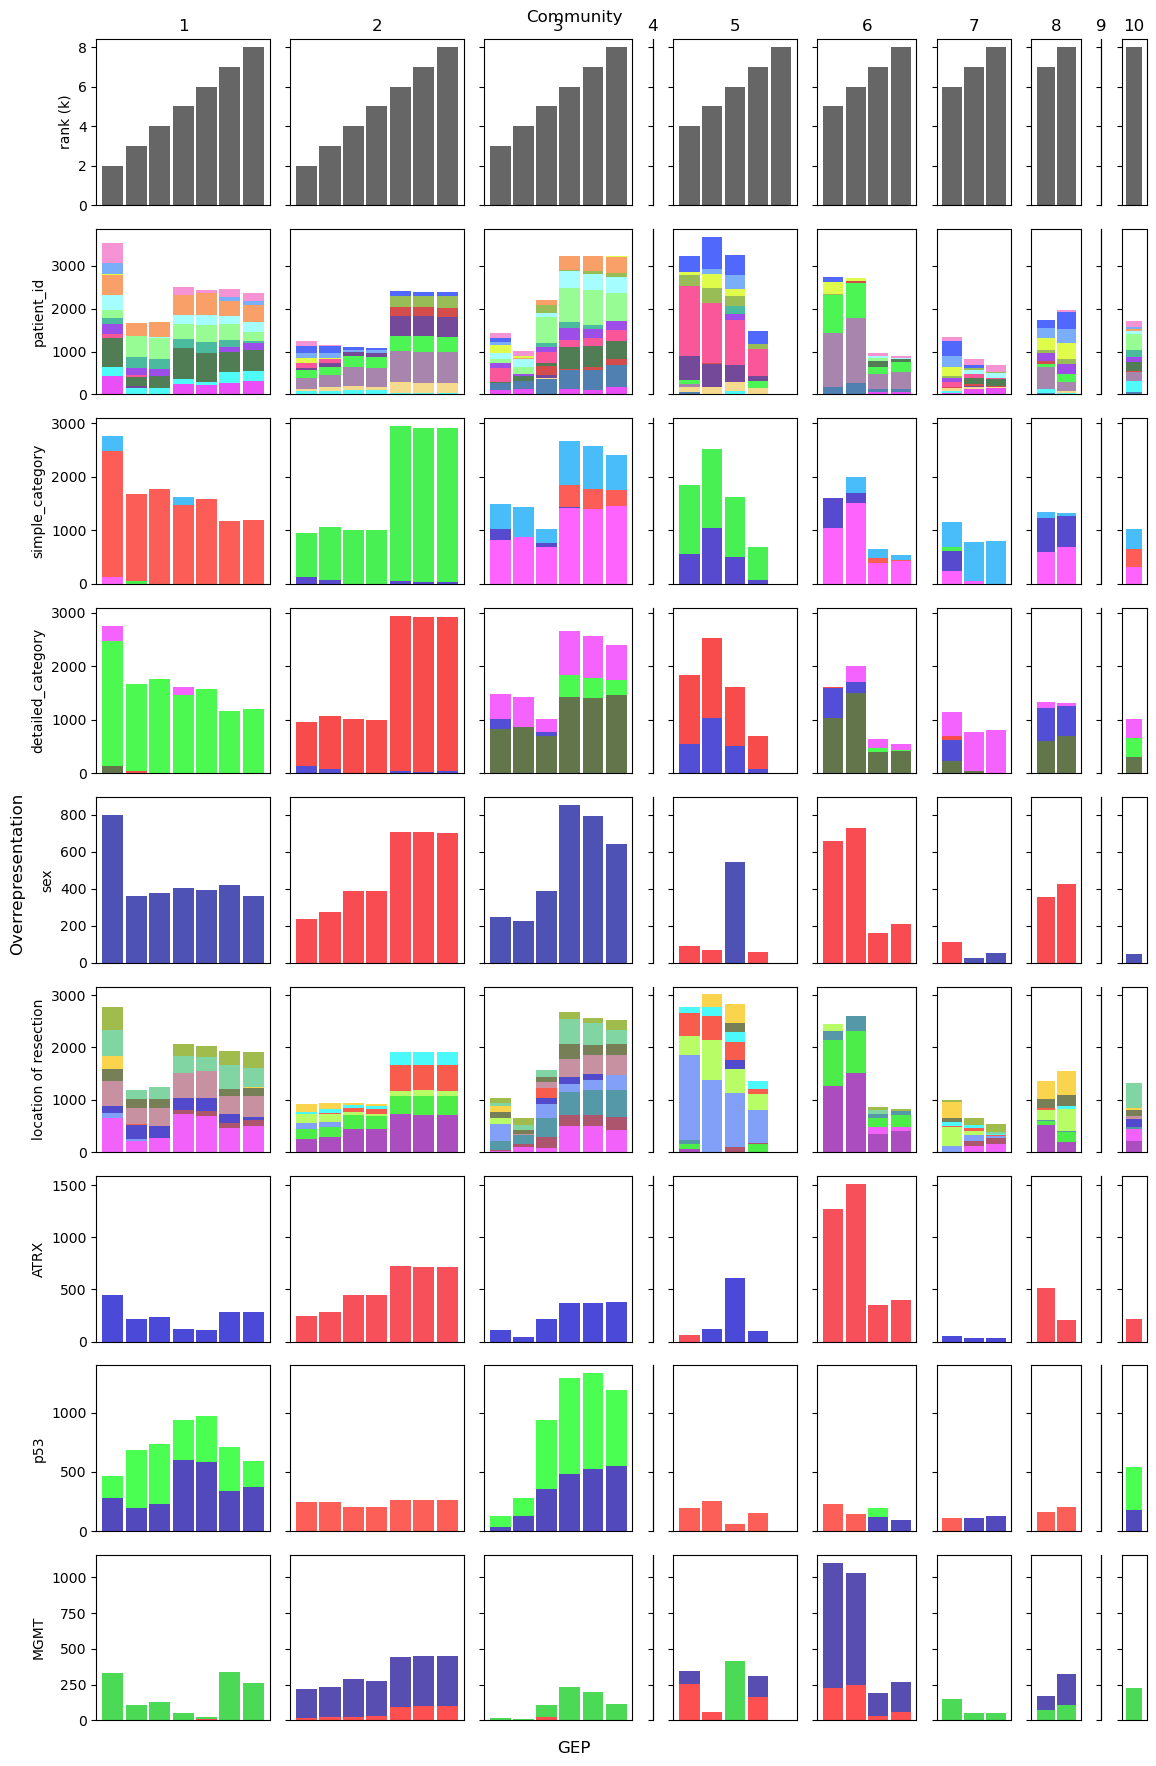

In [34]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

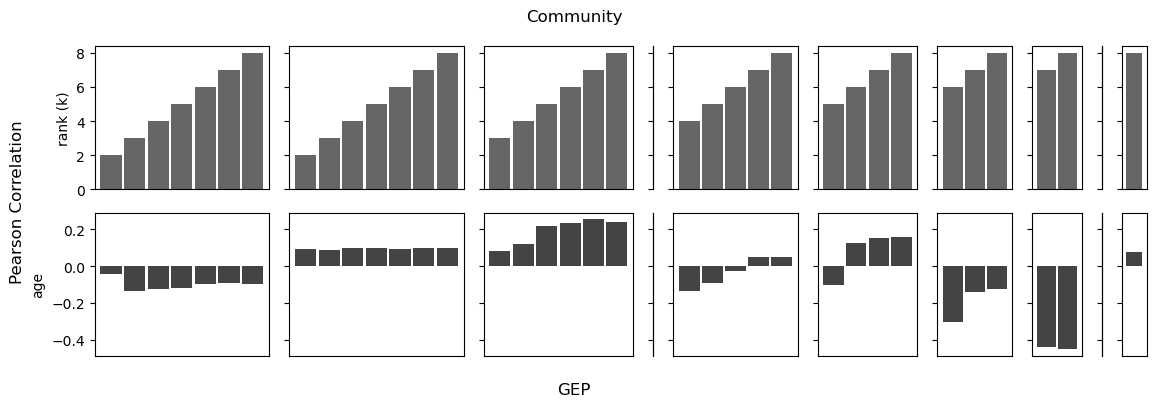

In [35]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

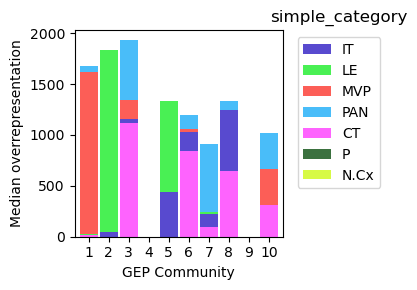

In [36]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

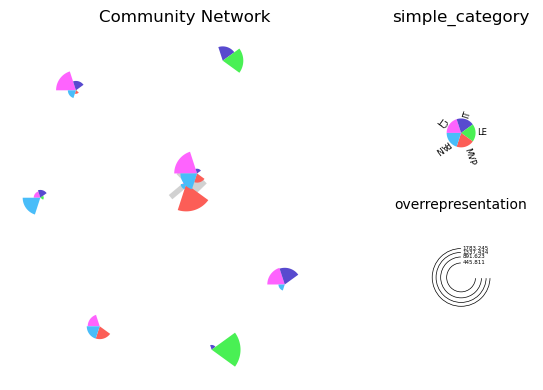

In [37]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

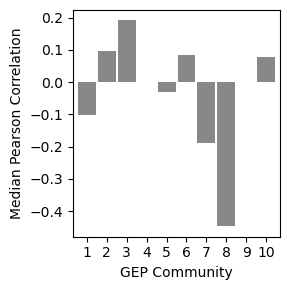

In [38]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

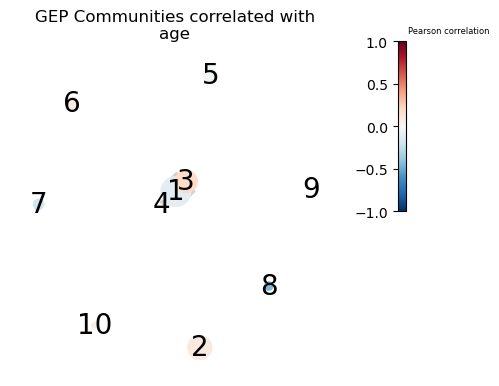

In [39]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

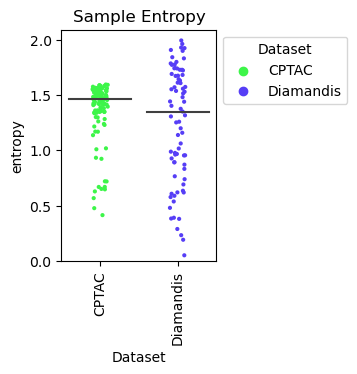

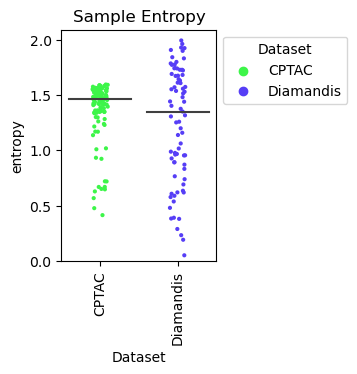

In [40]:
cn.plot_sample_entropy(snsmap, colors)